<a href="https://colab.research.google.com/github/Ve-Po/Task/blob/main/result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Библиотеки

In [120]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm
import random
import numpy as np
import math
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from PIL import Image,  ImageDraw

import os
import json

%matplotlib inline

Создание датасета геометрических фигур

In [121]:


def create_balanced_dataset(
    base_dir="geometric_shapes",
    images_per_shape=400,
    image_size=(256, 256),
    shapes=["circle", "square", "triangle", "rectangle", "pentagon", "star"],
    fill_probability=0.5,
    colors=["red", "green", "blue", "yellow", "purple", "orange"],
    background_color="white",
    min_size=20,
    max_size=80,
    add_rotation=True,
):
    os.makedirs(base_dir, exist_ok=True)
    for shape in shapes:
        os.makedirs(os.path.join(base_dir, shape), exist_ok=True)
    image_counter = 0

    for shape in shapes:
        for i in range(images_per_shape):
            color = random.choice(colors)
            filled = random.random() < fill_probability
            rotation = random.randint(0, 359) if add_rotation else 0


            size = random.randint(min_size, max_size)
            x = random.randint(size, image_size[0] - size)
            y = random.randint(size, image_size[1] - size)

            image = Image.new("RGB", image_size, background_color)
            draw = ImageDraw.Draw(image)

            if shape == "circle":
                bbox = (x - size, y - size, x + size, y + size)
                if filled:
                    draw.ellipse(bbox, fill=color)
                else:
                    draw.ellipse(bbox, outline=color, width=random.randint(1, 3))

            elif shape == "square":
                half_size = size // 2
                points = [
                    (x - half_size, y - half_size),
                    (x + half_size, y - half_size),
                    (x + half_size, y + half_size),
                    (x - half_size, y + half_size)
                ]
                if rotation != 0:
                    points = rotate_points(points, (x, y), math.radians(rotation))
                bbox = calculate_bbox(points)
                if filled:
                    draw.polygon(points, fill=color)
                else:
                    for i in range(len(points)):
                        draw.line([points[i], points[(i+1)%4]], fill=color, width=random.randint(1, 3))

            elif shape == "triangle":
                points = [
                    (x, y - size),
                    (x + size, y + size),
                    (x - size, y + size)
                ]
                if rotation != 0:
                    points = rotate_points(points, (x, y), math.radians(rotation))
                bbox = calculate_bbox(points)
                if filled:
                    draw.polygon(points, fill=color)
                else:
                    for i in range(len(points)):
                        draw.line([points[i], points[(i+1)%3]], fill=color, width=random.randint(1, 3))

            elif shape == "rectangle":
                width = size
                height = random.randint(min_size, max_size)
                half_width = width // 2
                half_height = height // 2
                points = [
                    (x - half_width, y - half_height),
                    (x + half_width, y - half_height),
                    (x + half_width, y + half_height),
                    (x - half_width, y + half_height)
                ]
                if rotation != 0:
                    points = rotate_points(points, (x, y), math.radians(rotation))
                bbox = calculate_bbox(points)
                if filled:
                    draw.polygon(points, fill=color)
                else:
                    for i in range(len(points)):
                        draw.line([points[i], points[(i+1)%4]], fill=color, width=random.randint(1, 3))

            elif shape == "pentagon":
                points = []
                for i in range(5):
                    angle = 2 * math.pi * i / 5 - math.pi / 2
                    points.append((x + size * math.cos(angle), y + size * math.sin(angle)))
                if rotation != 0:
                    points = rotate_points(points, (x, y), math.radians(rotation))
                bbox = calculate_bbox(points)
                if filled:
                    draw.polygon(points, fill=color)
                else:
                    for i in range(len(points)):
                        draw.line([points[i], points[(i+1)%5]], fill=color, width=random.randint(1, 3))

            elif shape == "star":
                outer_radius = size
                inner_radius = size // 2
                points = []
                for i in range(5):
                    angle = 2 * math.pi * i / 5 - math.pi / 2
                    points.append((x + outer_radius * math.cos(angle),
                                   y + outer_radius * math.sin(angle)))
                    angle += 2 * math.pi / 10
                    points.append((x + inner_radius * math.cos(angle),
                                   y + inner_radius * math.sin(angle)))
                if rotation != 0:
                    points = rotate_points(points, (x, y), math.radians(rotation))
                bbox = calculate_bbox(points)
                if filled:
                    draw.polygon(points, fill=color)
                else:
                    for i in range(len(points)):
                        draw.line([points[i], points[(i+1)%10]], fill=color, width=random.randint(1, 3))


            filename = f"{shape}_{image_counter:04d}.png"
            image.save(os.path.join(base_dir, shape, filename))

            image_counter += 1


def generate_balanced_train_val_datasets(
    base_dir="dataset",
    train_dir="train",
    val_dir="validation",
    images_per_shape=400,
    train_val_ratio=0.8,  # 80% train, 20% validation
    image_size=(256, 256),
    shapes=["circle", "square", "triangle", "rectangle", "pentagon", "star"],
    fill_probability=0.5,
    colors=["red", "green", "blue", "yellow", "purple", "orange"],
    background_color="white",
    min_size=20,
    max_size=80,
    train_rotation=True,
    val_rotation=True,
):
    """
    Генерация тренировочного и валидационного датасетов,
    у каждой фигуры одинаковое кол-во изображений
    """
    train_dataset_dir = os.path.join(base_dir, train_dir)
    val_dataset_dir = os.path.join(base_dir, val_dir)

    train_per_shape = int(images_per_shape * train_val_ratio)
    val_per_shape = images_per_shape - train_per_shape

    print(f"Генерация тренировочного датасета ({train_per_shape} изображений на класс)...")
    create_balanced_dataset(
        base_dir=train_dataset_dir,
        images_per_shape=train_per_shape,
        image_size=image_size,
        shapes=shapes,
        fill_probability=fill_probability,
        colors=colors,
        background_color=background_color,
        min_size=min_size,
        max_size=max_size,
        add_rotation=train_rotation,
    )

    print(f"Генерация валидационного датасета ({val_per_shape} изображений на класс)...")
    create_balanced_dataset(
        base_dir=val_dataset_dir,
        images_per_shape=val_per_shape,
        image_size=image_size,
        shapes=shapes,
        fill_probability=fill_probability,
        colors=colors,
        background_color=background_color,
        min_size=min_size,
        max_size=max_size,
        add_rotation=val_rotation,
    )

    print(f"датасеты успешно сгенерированы в {base_dir}!")
    print(f"Всего тренировочных изображений: {train_per_shape * len(shapes)}")
    print(f"Всего валидационных изображений: {val_per_shape * len(shapes)}")

def rotate_points(points, center, angle_rad):
    cx, cy = center
    rotated = []
    for x, y in points:
        dx = x - cx
        dy = y - cy
        new_x = cx + dx * math.cos(angle_rad) - dy * math.sin(angle_rad)
        new_y = cy + dx * math.sin(angle_rad) + dy * math.cos(angle_rad)
        rotated.append((new_x, new_y))
    return rotated

def calculate_bbox(points):
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    return (min(xs), min(ys), max(xs), max(ys))

if __name__ == "__main__":
    generate_balanced_train_val_datasets(
        images_per_shape=400,  # Ровно 100 изображений каждого класса (80 train + 20 val)
        train_val_ratio=0.8    # 80% train, 20% validation
    )

Генерация тренировочного датасета (320 изображений на класс)...
Генерация валидационного датасета (80 изображений на класс)...
датасеты успешно сгенерированы в dataset!
Всего тренировочных изображений: 1920
Всего валидационных изображений: 480


Модель
без особых аугментаций


In [122]:
# Установка Seed для воспроизводимости
seed = 111
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [123]:
model = models.resnet18(weights = True)
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:
train_data_dir = 'dataset/train'
val_data_dir = 'dataset/validation'

train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Классы в train:", train_dataset.classes)
print("Количество изображений в train:", [len(os.listdir(os.path.join(train_data_dir, cls))) for cls in train_dataset.classes])

Классы в train: ['circle', 'pentagon', 'rectangle', 'square', 'star', 'triangle']
Количество изображений в train: [320, 320, 320, 320, 320, 320]


Классы



In [125]:
classes_list = train_dataset.classes
print(classes_list)

['circle', 'pentagon', 'rectangle', 'square', 'star', 'triangle']


Распределение классов в тренировочной и валидационной выборке

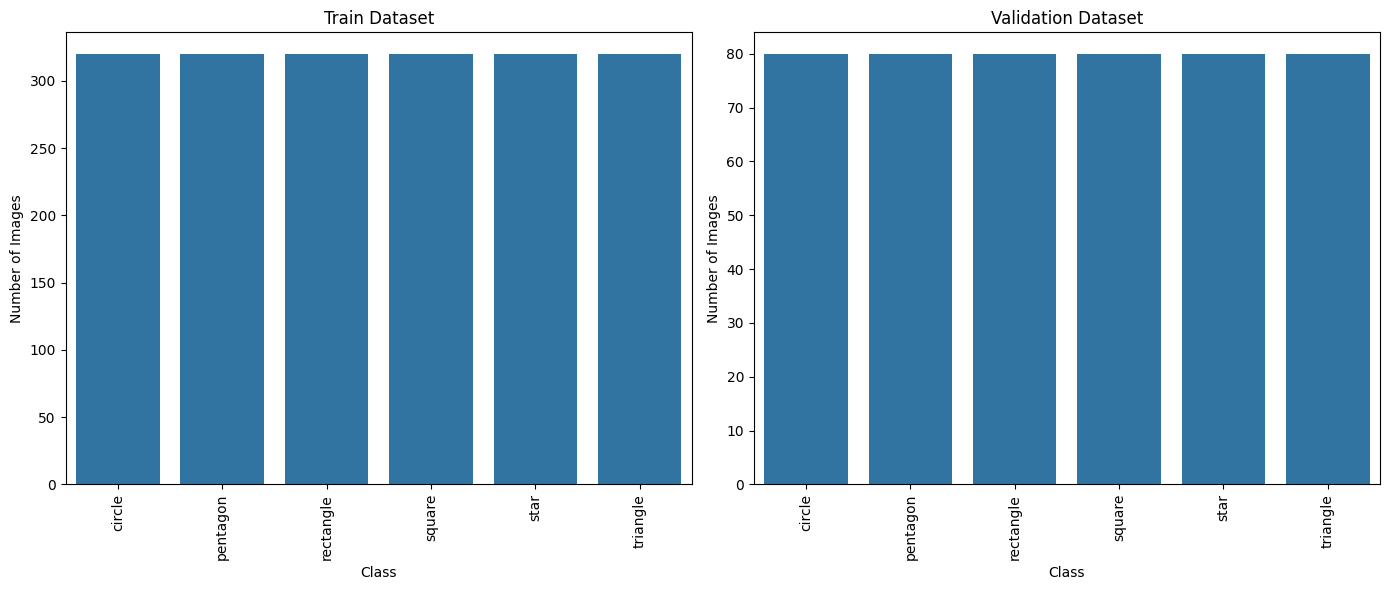

In [126]:

train_class_counts = np.zeros(len(train_dataset.classes))
for _, label in train_dataset:
    train_class_counts[label] += 1
val_class_counts = np.zeros(len(val_dataset.classes))
for _, label in val_dataset:
    val_class_counts[label] += 1

fig, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.barplot(x=train_dataset.classes, y=train_class_counts, ax=ax[0])
ax[0].set_title('Train Dataset')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Images')
ax[0].tick_params(axis='x', rotation=90)

sns.barplot(x=val_dataset.classes, y=val_class_counts, ax=ax[1])
ax[1].set_title('Validation Dataset')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Images')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Нормализация изображений


In [128]:
def show_images(images, denormalize=False):
    if denormalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()
images, _ = next(iter(train_loader))



Валидация модели до обучения

In [129]:
model.eval()
model.to(device)
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
val_accuracy = correct / total
print(val_accuracy)

100%|██████████| 8/8 [00:01<00:00,  4.64it/s]

0.19166666666666668


Обучение сети

In [130]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

num_epochs = 70

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
model.to(device)

patience = 5 # Количество эпох без улучшения, после которых обучение останавливается
counter = 0
best_model_path = 'best_model.pth'


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валидация модели
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

    # Сохранение лучшей модели на основе валидационной точности и early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), best_model_path)
        print('Saved best model!')
        counter = 0
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')

    torch.save(model.state_dict(), 'last_model.pth')
    print()

    if counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs!')
        break  # Прекращение обучения

print('Training and validation complete!')


100%|██████████| 8/8 [00:01<00:00,  5.02it/s]


Epoch [1/70], Train Loss: 0.4752, Train Accuracy: 0.7766, Val Loss: 1.1122, Val Accuracy: 0.6542
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.11it/s]


Epoch [2/70], Train Loss: 0.2852, Train Accuracy: 0.8490, Val Loss: 0.2288, Val Accuracy: 0.8938
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.08it/s]


Epoch [3/70], Train Loss: 0.1984, Train Accuracy: 0.9031, Val Loss: 0.1905, Val Accuracy: 0.9083
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  4.64it/s]


Epoch [4/70], Train Loss: 0.1846, Train Accuracy: 0.9146, Val Loss: 0.3724, Val Accuracy: 0.8708
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:02<00:00,  3.70it/s]


Epoch [5/70], Train Loss: 0.1783, Train Accuracy: 0.9245, Val Loss: 0.4299, Val Accuracy: 0.8417
EarlyStopping counter: 2 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.02it/s]


Epoch [6/70], Train Loss: 0.1889, Train Accuracy: 0.9120, Val Loss: 1.3158, Val Accuracy: 0.6208
EarlyStopping counter: 3 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.05it/s]


Epoch [7/70], Train Loss: 0.1513, Train Accuracy: 0.9292, Val Loss: 0.1908, Val Accuracy: 0.9042
EarlyStopping counter: 4 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.09it/s]


Epoch [8/70], Train Loss: 0.1131, Train Accuracy: 0.9516, Val Loss: 0.1480, Val Accuracy: 0.9396
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  4.91it/s]


Epoch [9/70], Train Loss: 0.0929, Train Accuracy: 0.9693, Val Loss: 0.2110, Val Accuracy: 0.8854
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.07it/s]


Epoch [10/70], Train Loss: 0.0758, Train Accuracy: 0.9693, Val Loss: 0.3283, Val Accuracy: 0.9167
EarlyStopping counter: 2 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.04it/s]


Epoch [11/70], Train Loss: 0.0850, Train Accuracy: 0.9698, Val Loss: 0.2262, Val Accuracy: 0.9146
EarlyStopping counter: 3 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.10it/s]


Epoch [12/70], Train Loss: 0.0485, Train Accuracy: 0.9828, Val Loss: 0.3731, Val Accuracy: 0.8896
EarlyStopping counter: 4 out of 5



100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch [13/70], Train Loss: 0.0619, Train Accuracy: 0.9786, Val Loss: 0.4037, Val Accuracy: 0.8458
EarlyStopping counter: 5 out of 5

Early stopping triggered after 13 epochs!
Training and validation complete!


Построим графики

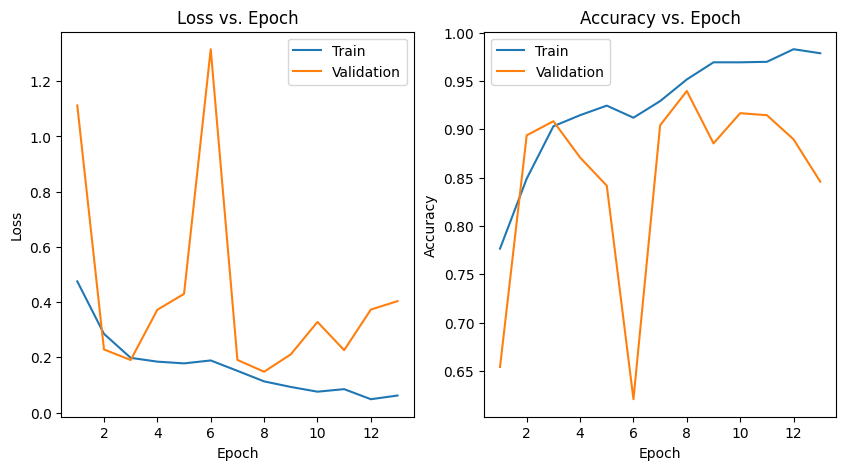

In [132]:

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 13
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()


In [133]:

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Metrics for current model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      0.99      0.99        80
           2       0.85      0.79      0.82        80
           3       0.79      0.86      0.83        80
           4       1.00      1.00      1.00        80
           5       1.00      1.00      1.00        80

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480

Test Accuracy: 0.9396


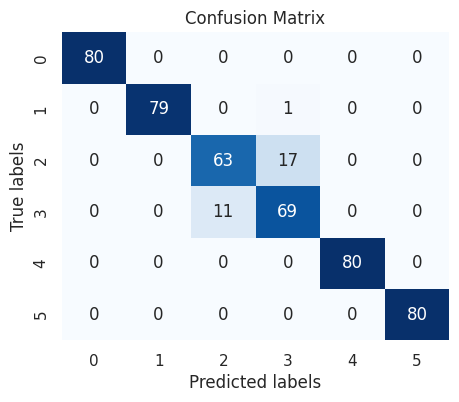

In [134]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model, val_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(6)))

С аугментациями

In [135]:
# Загрузим предварительно обученную модель ResNet18
model = models.resnet18(weights=True)

# Заменим последний слой (fully connected) так, чтобы количество выходных каналов соответствовало 3 классам
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [136]:

train_data_dir = 'dataset/train'
val_data_dir = 'dataset/validation'
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),  # Добавим вертикальное отражение
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# датасеты
train_dataset = ImageFolder(train_data_dir, transform=train_transforms)
val_dataset = ImageFolder(val_data_dir, transform=val_transforms)

#датагенераторы
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Images without normalization:


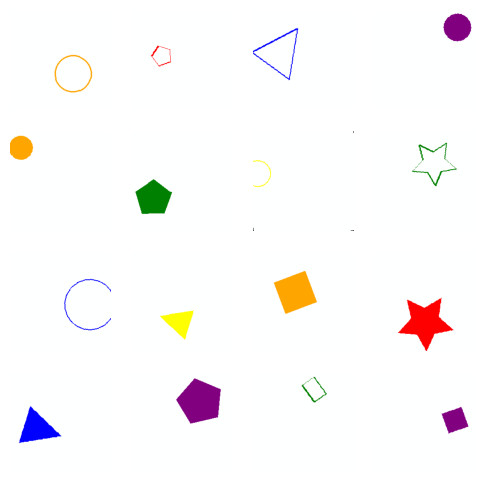

In [137]:
# Получение первого батча из тренировочного загрузчика данных
images, _ = next(iter(train_loader))

# Отображение изображений с восстановлением цветов
print("Images without normalization:")
show_images(images, denormalize=True)

код обучения

In [138]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

num_epochs = 70

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
model.to(device)
patience = 5
counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Валидация модели
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pth')
        print('Saved best model!')
        counter = 0
    else:
        counter += 1
        print(f'EarlyStopping counter: {counter} out of {patience}')

    torch.save(model.state_dict(), 'last_model.pth')
    print()
    if counter >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs!')
        break

print('Training and validation complete!')

100%|██████████| 8/8 [00:01<00:00,  4.99it/s]


Epoch [1/70], Train Loss: 0.4616, Train Accuracy: 0.8063, Val Loss: 0.2223, Val Accuracy: 0.8667
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  4.81it/s]


Epoch [2/70], Train Loss: 0.2172, Train Accuracy: 0.9010, Val Loss: 0.2969, Val Accuracy: 0.8792
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.02it/s]


Epoch [3/70], Train Loss: 0.2017, Train Accuracy: 0.9010, Val Loss: 0.1591, Val Accuracy: 0.9229
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.18it/s]


Epoch [4/70], Train Loss: 0.1968, Train Accuracy: 0.9161, Val Loss: 0.1665, Val Accuracy: 0.9167
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.60it/s]


Epoch [5/70], Train Loss: 0.1588, Train Accuracy: 0.9292, Val Loss: 0.1362, Val Accuracy: 0.9313
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Epoch [6/70], Train Loss: 0.1419, Train Accuracy: 0.9406, Val Loss: 0.1535, Val Accuracy: 0.9229
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.97it/s]


Epoch [7/70], Train Loss: 0.1354, Train Accuracy: 0.9453, Val Loss: 0.1479, Val Accuracy: 0.9229
EarlyStopping counter: 2 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Epoch [8/70], Train Loss: 0.1372, Train Accuracy: 0.9396, Val Loss: 0.1976, Val Accuracy: 0.9146
EarlyStopping counter: 3 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Epoch [9/70], Train Loss: 0.1446, Train Accuracy: 0.9365, Val Loss: 0.1442, Val Accuracy: 0.9333
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  6.01it/s]


Epoch [10/70], Train Loss: 0.1429, Train Accuracy: 0.9354, Val Loss: 0.1248, Val Accuracy: 0.9417
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.90it/s]


Epoch [11/70], Train Loss: 0.1393, Train Accuracy: 0.9437, Val Loss: 0.1700, Val Accuracy: 0.9229
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.94it/s]


Epoch [12/70], Train Loss: 0.1353, Train Accuracy: 0.9437, Val Loss: 0.1326, Val Accuracy: 0.9458
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


Epoch [13/70], Train Loss: 0.1186, Train Accuracy: 0.9516, Val Loss: 0.1430, Val Accuracy: 0.9354
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Epoch [14/70], Train Loss: 0.1315, Train Accuracy: 0.9469, Val Loss: 0.1152, Val Accuracy: 0.9563
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  5.93it/s]


Epoch [15/70], Train Loss: 0.1181, Train Accuracy: 0.9536, Val Loss: 0.1182, Val Accuracy: 0.9458
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.05it/s]


Epoch [16/70], Train Loss: 0.1036, Train Accuracy: 0.9599, Val Loss: 0.1467, Val Accuracy: 0.9479
EarlyStopping counter: 2 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Epoch [17/70], Train Loss: 0.1268, Train Accuracy: 0.9500, Val Loss: 0.1553, Val Accuracy: 0.9396
EarlyStopping counter: 3 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Epoch [18/70], Train Loss: 0.1080, Train Accuracy: 0.9573, Val Loss: 0.0961, Val Accuracy: 0.9583
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Epoch [19/70], Train Loss: 0.0942, Train Accuracy: 0.9599, Val Loss: 0.1247, Val Accuracy: 0.9479
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.03it/s]


Epoch [20/70], Train Loss: 0.1069, Train Accuracy: 0.9563, Val Loss: 0.0922, Val Accuracy: 0.9583
EarlyStopping counter: 2 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.14it/s]


Epoch [21/70], Train Loss: 0.1075, Train Accuracy: 0.9594, Val Loss: 0.1234, Val Accuracy: 0.9521
EarlyStopping counter: 3 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.07it/s]


Epoch [22/70], Train Loss: 0.0921, Train Accuracy: 0.9630, Val Loss: 0.1155, Val Accuracy: 0.9521
EarlyStopping counter: 4 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.02it/s]


Epoch [23/70], Train Loss: 0.0985, Train Accuracy: 0.9646, Val Loss: 0.0954, Val Accuracy: 0.9625
Saved best model!



100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Epoch [24/70], Train Loss: 0.0846, Train Accuracy: 0.9672, Val Loss: 0.1289, Val Accuracy: 0.9417
EarlyStopping counter: 1 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.00it/s]


Epoch [25/70], Train Loss: 0.0887, Train Accuracy: 0.9667, Val Loss: 0.0948, Val Accuracy: 0.9625
EarlyStopping counter: 2 out of 5



100%|██████████| 8/8 [00:01<00:00,  6.13it/s]


Epoch [26/70], Train Loss: 0.0777, Train Accuracy: 0.9724, Val Loss: 0.1257, Val Accuracy: 0.9500
EarlyStopping counter: 3 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.95it/s]


Epoch [27/70], Train Loss: 0.0981, Train Accuracy: 0.9609, Val Loss: 0.1229, Val Accuracy: 0.9563
EarlyStopping counter: 4 out of 5



100%|██████████| 8/8 [00:01<00:00,  5.90it/s]

Epoch [28/70], Train Loss: 0.1094, Train Accuracy: 0.9563, Val Loss: 0.1331, Val Accuracy: 0.9417
EarlyStopping counter: 5 out of 5

Early stopping triggered after 28 epochs!
Training and validation complete!


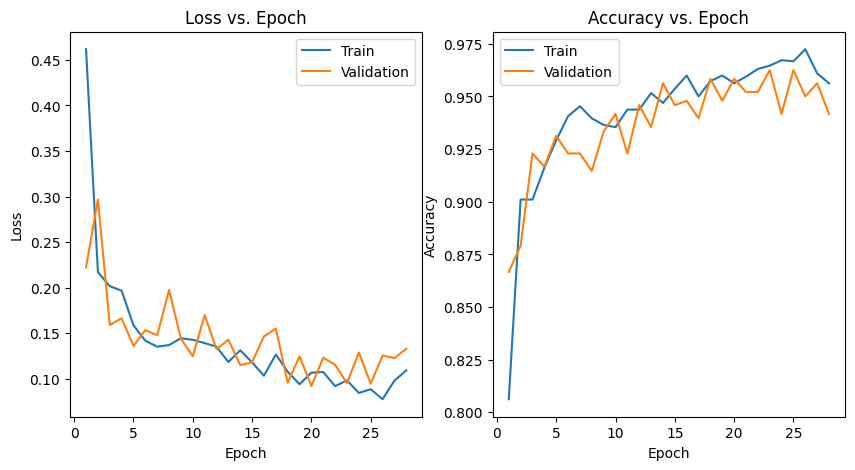

In [140]:
# Построим графики
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
num_epochs = 28
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

Metrics for current model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80
           2       0.97      0.80      0.88        80
           3       0.83      0.97      0.90        80
           4       1.00      1.00      1.00        80
           5       1.00      1.00      1.00        80

    accuracy                           0.96       480
   macro avg       0.97      0.96      0.96       480
weighted avg       0.97      0.96      0.96       480

Test Accuracy: 0.9625


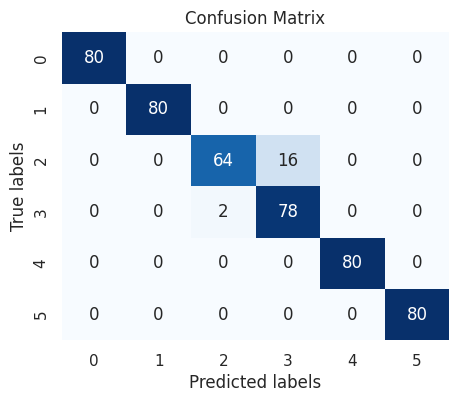

In [141]:
# Загрузка весов модели
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

# Оценка модели и построение матрицы ошибок
cm, report, accuracy_2, weighted_f1_2 = evaluate_model(model, val_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_2:.4f}')
plot_confusion_matrix(cm, classes=list(range(6)))

In [142]:
model = models.resnet18()
num_classes = 6
model.fc = nn.Linear(model.fc.in_features, num_classes)

model.load_state_dict(torch.load('best_model.pth'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

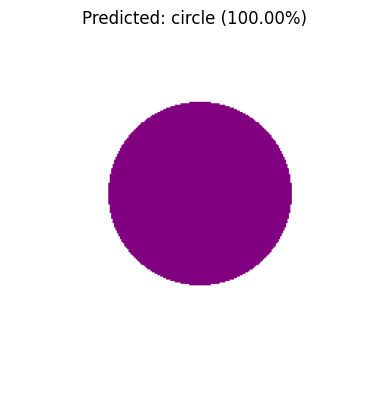

In [144]:

image_path = 'dataset/validation/circle/circle_0000.png'
image = Image.open(image_path)
image_tensor = preprocess(image)
image_tensor = image_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(image_tensor)

probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()

top_prob, top_class = torch.topk(probabilities, 1)
top_prob = top_prob.item()
top_class = top_class.item()


class_names = ['circle', 'pentagon', 'rectangle', 'square', 'star', 'triangle']
class_name = class_names[top_class]

plt.imshow(image)
plt.axis('off')
plt.title(f'Predicted: {class_name} ({top_prob*100:.2f}%)')
plt.show()

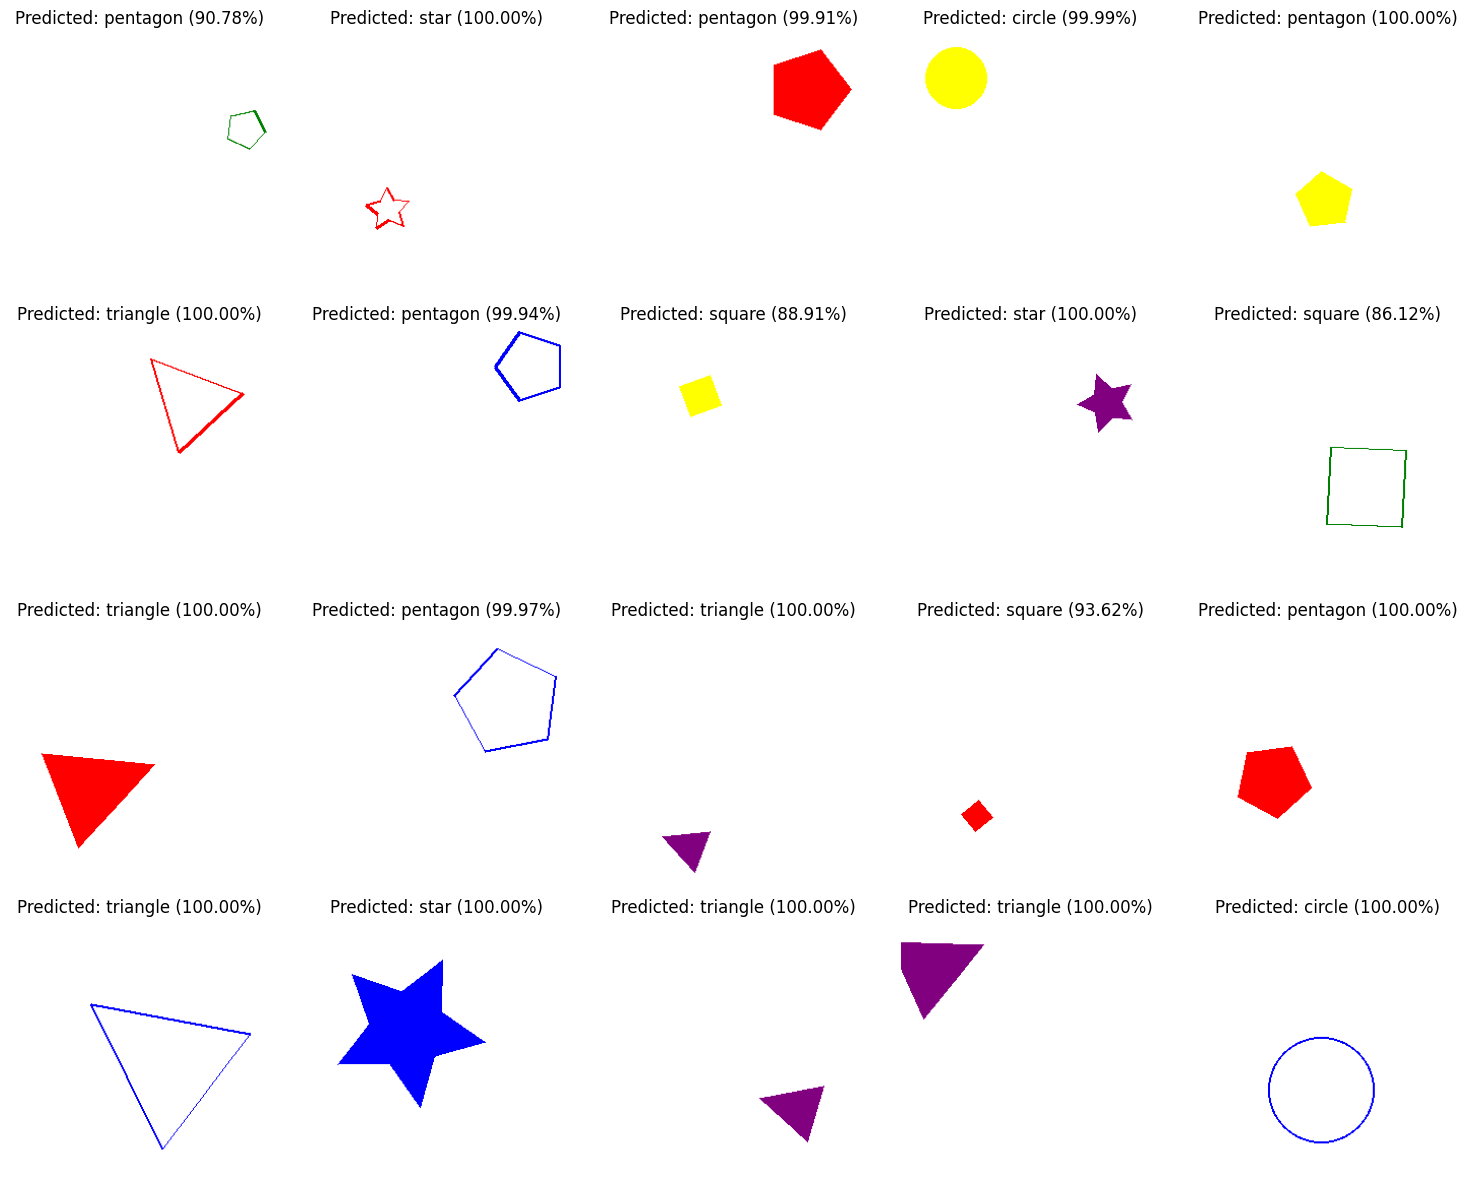

In [146]:
import random

class_names = ['circle', 'pentagon', 'rectangle', 'square', 'star', 'triangle']  # Замените на список классов

image_dir = 'dataset/validation/'

image_paths = []
for class_name in os.listdir(image_dir):
    class_dir = os.path.join(image_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            if image_name.endswith(('.png')):
                image_path = os.path.join(class_dir, image_name)
                image_paths.append(image_path)

random.shuffle(image_paths)

num_images_to_show = min(20, len(image_paths))

# Отображение результатов
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
axes = axes.ravel()

for i in range(num_images_to_show):
    image_path = image_paths[i]
    image = Image.open(image_path)
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0).cpu()
        top_prob, top_class = torch.topk(probabilities, 1)
        top_prob = top_prob.item()
        class_name = class_names[top_class]

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'Predicted: {class_name} ({top_prob*100:.2f}%)')

plt.tight_layout()
plt.show()